<a href="https://colab.research.google.com/github/sjdhola/HPC-Lab/blob/main/SRI_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyclustertend
!pip install tabulate

import math
import copy
import heapq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
from math import isnan
from random import sample
from tabulate import tabulate
from numpy.random import uniform
from mpl_toolkits import mplot3d
from pyclustertend import hopkins
from sklearn.cluster import KMeans
from matplotlib.pyplot import style
from sklearn.cluster import MeanShift
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
style.use("seaborn-whitegrid")

In [3]:
import random

def DataGen(num, ok=False):
    randomlist = []
    for i in range(0,num):
        n = random.randint(1,100)
        randomlist.append(n)
    P = randomlist
    if ok==True:
        return P

    randomlist = []
    for i in range(0,num):
        n = random.randint(1,100)
        if i<=5:
            n = 0
        randomlist.append(n)
    AT=randomlist
    AT = sorted(AT)

    randomlist = []
    for i in range(0,num):
        n = random.randint(1,100)
        randomlist.append(n)
    kernel=randomlist

    X=np.array([AT,P,kernel])
    X=np.transpose(X)
    return X

from random import gauss

def DataGen_1(num,mean,std, ok=False):
    randomlist = []
    for i in range(0,num):
        n = abs(gauss(mean,std))
        randomlist.append(n)
    P = randomlist

    if ok==True:
        return P
    
    randomlist = []
    for i in range(0,num):
        n = random.randint(1,100)
        if i<=5:
            n = 0
        randomlist.append(n)
    AT = randomlist
    AT = sorted(AT)

    randomlist = []
    for i in range(0,num):
        n = random.randint(1,100)
        randomlist.append(n)
    kernel=randomlist

    X=np.array([AT,P,kernel])
    X=np.transpose(X)
    return X

In [4]:
l = []

def find_label(a, p):
    dist = np.array([sum((a[i] - p) * (a[i] - p)) for i in range(len(a))])
    return np.argmin(dist)


def K_means_Clustering(Process, k, Plot, itr, Rlabel, Plot3D=False, axi=[]):
    Best_SSE = np.inf
    p_f = []
    label_f = []
    for it in range(itr):
        random_indices = np.random.choice(len(Process), size=k, replace=False)
        p = Process[random_indices, :]
        label = np.array([find_label(p, i) for i in Process])
        pl = label
        while True:
            dist = np.zeros((k, len(Process[0])))
            for i in range(len(label)):
                dist[label[i], :] = dist[label[i], :] + Process[i, :]
            for i in range(len(dist)):
                if np.count_nonzero(label == i) != 0:
                    dist[i, :] = dist[i, :] / np.count_nonzero(label == i)
            label = np.array([find_label(dist, i) for i in Process])
            p = dist
            ok = True
            for i in range(len(label)):
                if label[i] != pl[i]:
                    ok = False
                    break
            if ok == True:
                break
            pl = label
        sse = 0
        for i in range(len(Process)):
            sse += math.sqrt(sum((Process[i] - p[label[i]]) * (Process[i] - p[label[i]])))
        if sse < Best_SSE:
            Best_SSE = sse
            p_f = p
            label_f = label
    label = label_f
    l = label_f
    p = p_f
    sse = Best_SSE
    if Plot == True and Plot3D == False:
        C = 10 * ["r", "g", "b", "c", "k", "y", "m"]
        for i in range(len(Process)):
            plt.scatter(Process[i][0], Process[i][1], c=C[label[i]])
        for i in range(len(p)):
            plt.scatter(p[i][0], p[i][1], c=C[k], marker="x")
        plt.xlabel(axi[0])
        plt.ylabel(axi[1])
        plt.title("K-Means Clustering")
        plt.show()
    elif Plot3D == True:
        C = 10 * ["a", "b", "c", "d", "e", "f", "g"]
        c = []
        for i in range(len(Process)):
            c.append(C[label[i]])
        df = pd.DataFrame(Process, columns=["Burst time", "Process weight", "NCS"])
        df["Class"] = c
        fig = px.scatter_3d(
            df,
            x="Burst time",
            y="Process weight",
            z="NCS",
            color="Class",
            title="K-Means Clustering",
        )
        fig.show()
    if Rlabel == True:
        return sse, label
    return sse


def kmeans(X, n_clusters):
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    y_pred = km.predict(X)
    return y_pred

def Silhouette_Test(X, Plot):
    range_n_clusters = []
    for i in range(2,min(len(X),6),1):
        range_n_clusters.append(i)
    k=0
    mx=-10
    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg>mx:
            mx=silhouette_avg
            k = n_clusters
    if Plot==False:
      return k
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[
                cluster_labels == i
            ]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )
        centers = clusterer.cluster_centers_
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        plt.suptitle(
            (
                "Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters
            ),
            fontsize=14,
            fontweight="bold",
        )
    plt.show()
    return k

In [5]:
def Plot_function(P):
    Weight = P/sum(P)
    STS = 10
    NCS = []
    for i in P:
        if i%STS == 0:
            NCS.append(i/STS -1)
        else:
            NCS.append(math.floor(i/STS) )
    NCS=np.array(NCS)
    X=np.array([P,Weight,NCS])
    X=np.transpose(X)
    k = Silhouette_Test(X,True)
    _ =  K_means_Clustering(X,k,False,1,True,True,True)

For n_clusters = 2 The average silhouette_score is : 0.8517756899455213
For n_clusters = 3 The average silhouette_score is : 0.7499790434290164
For n_clusters = 4 The average silhouette_score is : 0.6014217022708753
For n_clusters = 5 The average silhouette_score is : 0.5701390917989373


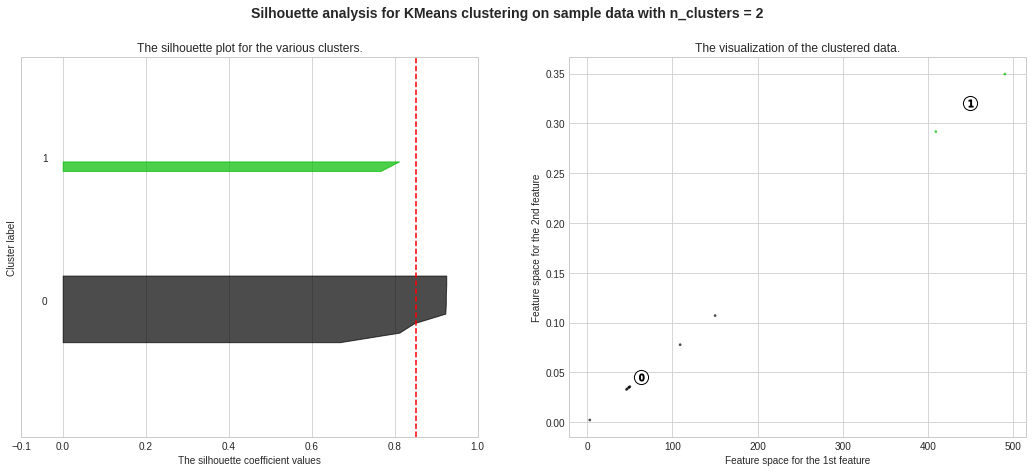

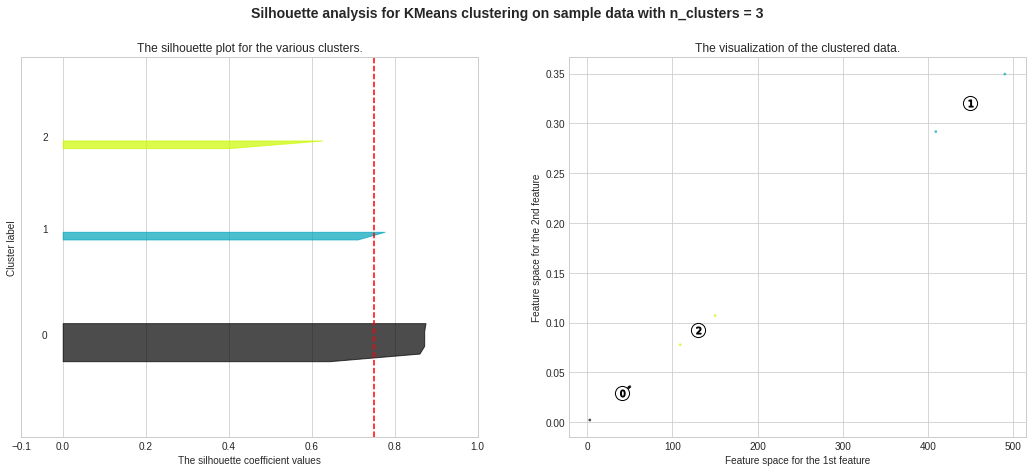

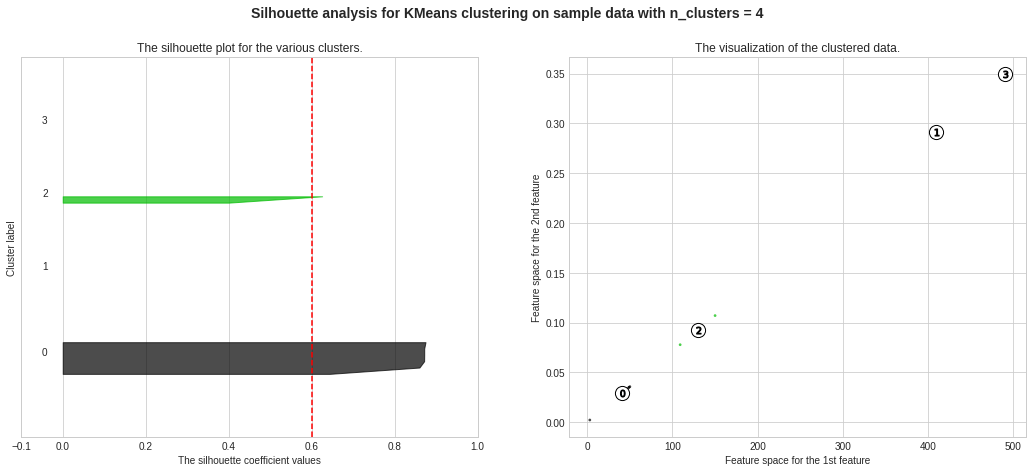

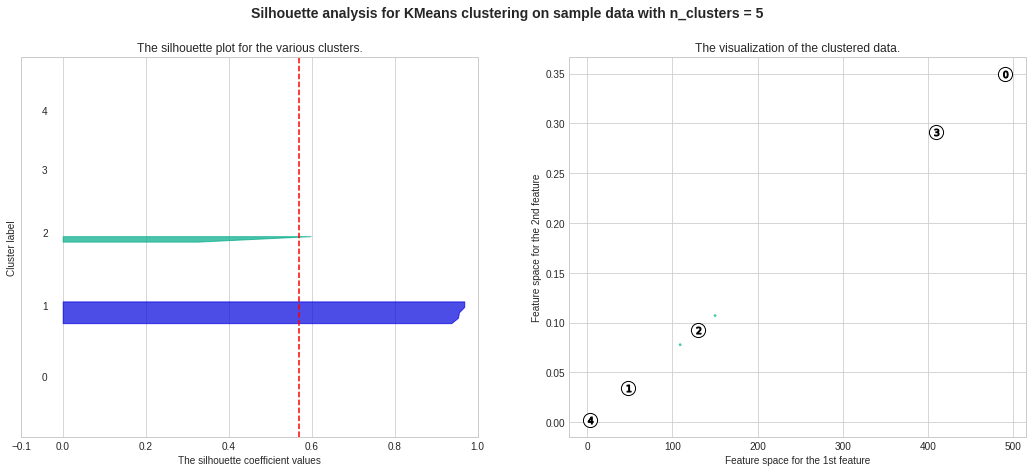

In [6]:
P =np.array([109,150,3,50,49,49,409,490,47,46])
Plot_function(P)

In [7]:
def TimeSlice_Generator ( P, STS ):
    P = np.array(P)
    Weight = P/sum(P)
    NCS = []
    for i in P:
        if i%STS == 0:
            NCS.append(i/STS -1)
        else:
            NCS.append(math.floor(i/STS))
    NCS=np.array(NCS)
    X=np.array([P,Weight,NCS])
    X=np.transpose(X)
    k = Silhouette_Test(X,False)

    _,label = K_means_Clustering(X,k,False,10,True,False,True)

    Cluster_weight = []
    for i in range(k):
        Cluster_weight.append(X[label==i][:,0].mean())

    Cluster_weight = Cluster_weight / sum(Cluster_weight)
    
    CTS = []
    for i in range(len(label)):
        CTS.append((1-Cluster_weight[label[i]])*STS)
    return CTS

#Without Arrival time
def Round_Robin( P ,Simple_RR,STS = 10):
    CTS = []
    NCS = 0
    if Simple_RR:
        CTS = [STS]*len(P)
    else:
        CTS = TimeSlice_Generator(P,STS)
    RT = copy.copy(P)
    Start_time = [0]*len(P)
    End_time = [0]*len(P)
    T=0
    Q = [i for i in range(len(P))]
    while( len(Q)>0 ):
        NCS+=1
        x = Q[0]
        Q.pop(0)
        time_to_execute = min(CTS[x],RT[x])
        T += CTS[x]
        RT[x] -= time_to_execute
        if RT[x]>0 and RT[x]<0.5*CTS[x] and Simple_RR==False:
            T+=CTS[x]
            RT[x]-=min(CTS[x],RT[x])
        if RT[x]==0:
            End_time[x] = T
        else:
            Q.append(x)
    Start_time = np.array(Start_time)
    End_time = np.array(End_time)
    Turn_Around_Time = End_time - Start_time
    Waiting_Time = Turn_Around_Time - P
    if Simple_RR:
        print("Number of context in normal round robin: ",NCS)
    else:
        print("Number of context in round robin with kmeans: ",NCS)
    return Turn_Around_Time,Waiting_Time, NCS

#With Arrival time
def Round_Robin_With_AT( Start_time , P , Simple_RR, STS = 10):
    RT = copy.copy(P)
    End_time = [0]*len(P)
    T = 0
    itr = 0 
    Q = []
    NCS = 0
    CTS = [STS]*len(Start_time)
    while itr<len(Start_time) and Start_time[itr]<=T:
        Q.append(itr)
        itr+=1
        
    while( len(Q)>0 ):
        NCS+=1
        while itr<len(Start_time) and Start_time[itr]<=T:
            Q.append(itr)
            itr+=1
            
        p = []
        for i in Q:
            p.append(RT[i])
        Temp_CTS = []
        if len(Q)>2 and Simple_RR == False:
            Temp_CTS = TimeSlice_Generator ( p, STS )
        else:
            Temp_CTS = [STS]*len(Q)
        for i in range(len(Q)):
            CTS[Q[i]] = Temp_CTS[i]
        x = Q[0]
        Q.pop(0)
        time_to_execute = min(CTS[x],RT[x])
        T += CTS[x]
        RT[x] -= time_to_execute
        if RT[x]>0 and RT[x]<0.5*CTS[x] and Simple_RR==False:
            T+=CTS[x]
            RT[x]-=min(CTS[x],RT[x])
        if RT[x]==0:
            End_time[x] = T
        else:
            Q.append(x)
    Start_time = np.array(Start_time)
    End_time = np.array(End_time)
    Turn_Around_Time = End_time - Start_time
    Waiting_Time = Turn_Around_Time - P
    if Simple_RR:
        print("Number of context in normal round robin: ",NCS)
    else:
        print("Number of context in round robin with kmeans: ",NCS)
    return Turn_Around_Time,Waiting_Time,NCS

#With Arrival time and priority.
def Round_Robin_With_AT_and_Priority( Start_time , P , Priority , Simple_RR, STS = 10):
    RT = copy.copy(P)
    End_time = [0]*len(P)
    T = 0
    itr = 0 
    Q = []
    NCS = 0
    CTS = [STS]*len(Start_time)
    while itr<len(Start_time) and Start_time[itr]<=T:
        Q.append((Priority[itr],itr))
        itr+=1
    while( len(Q)>0 ):
        NCS+=1
        while itr<len(Start_time) and Start_time[itr]<=T:
            Q.append((Priority[itr],itr))
            itr+=1
            
        heapq.heapify(Q)
        p = []
        for i in Q:
            p.append(RT[i[1]])
        Temp_CTS = []
        if len(Q)>2 and Simple_RR == False:
            Temp_CTS = TimeSlice_Generator ( p, STS )
        else:
            Temp_CTS = [STS]*len(Q)
        for i in range(len(Q)):
            CTS[Q[i][1]] = Temp_CTS[i]
        x = Q[0][1]
        Q.pop(0)
        time_to_execute = min(CTS[x],RT[x])
        T += CTS[x]
        RT[x] -= time_to_execute
        if RT[x]>0 and RT[x]<0.5*CTS[x] and Simple_RR==False:
            T+=CTS[x]
            RT[x]-=min(CTS[x],RT[x])
        #Priority[x]-=1
        if RT[x]==0:
            End_time[x] = T
        else:
            Q.append((Priority[x],x))
    Start_time = np.array(Start_time)
    End_time = np.array(End_time)
    Turn_Around_Time = End_time - Start_time
    Waiting_Time = Turn_Around_Time - P
    if Simple_RR:
        print("Number of context in normal round robin: ",NCS)
    else:
        print("Number of context in round robin with kmeans: ",NCS)
    return Turn_Around_Time,Waiting_Time,NCS

╒════╤════════════════╤════════════════╤════════════════════╕
│    │ Arrival Time   │ Process Time   │ Process priority   │
╞════╪════════════════╪════════════════╪════════════════════╡
│ 0  │ 0              │ 80.5778        │ 61                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 1  │ 0              │ 139.703        │ 13                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 2  │ 0              │ 101.555        │ 7                  │
├────┼────────────────┼────────────────┼────────────────────┤
│ 3  │ 0              │ 18.6511        │ 33                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 4  │ 0              │ 149.453        │ 42                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 5  │ 0              │ 75.8974        │ 100                │
├────┼────────────────┼────────────────┼────────────────────┤
│ 6  │ 8              │ 25.017         │ 7                  │
├────┼──

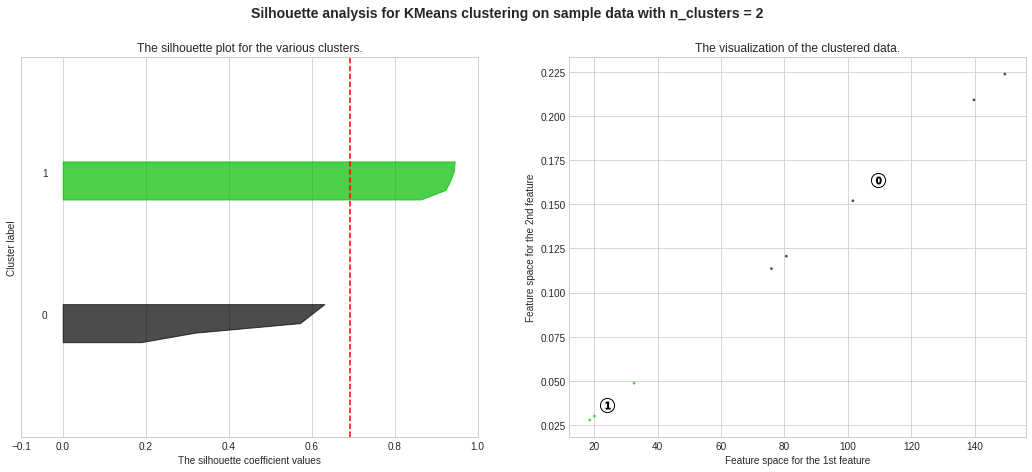

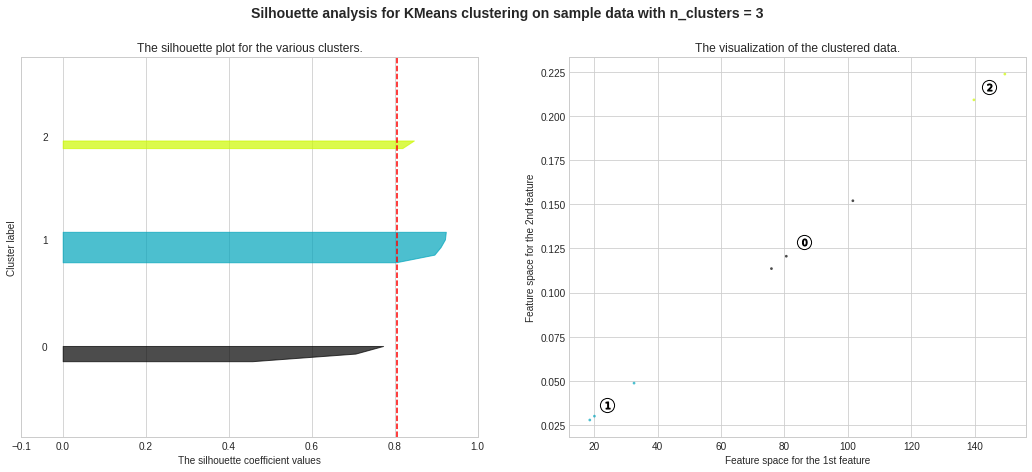

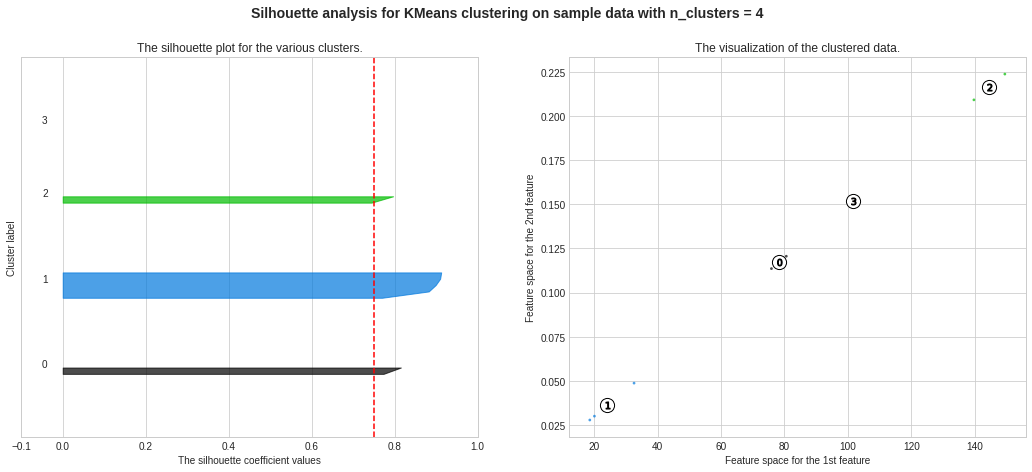

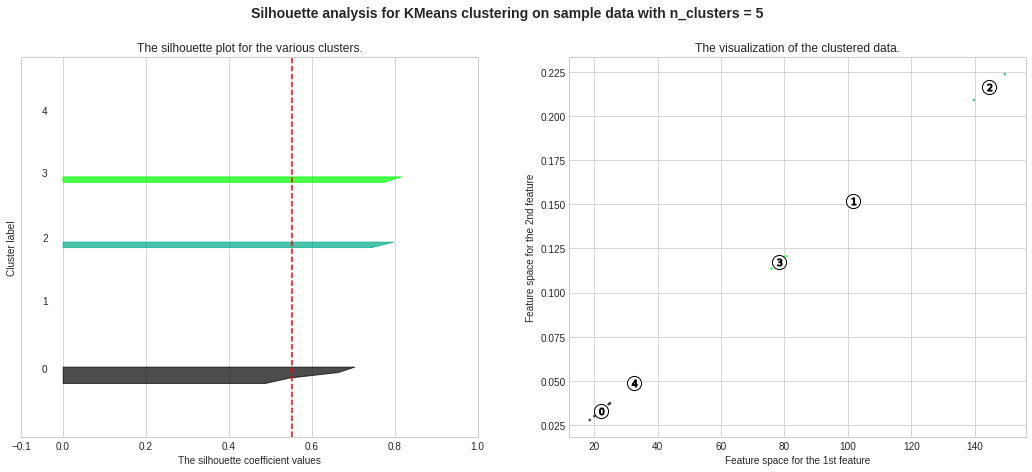

In [8]:
# With arrival time
#Data = DataGen(50)
Data = DataGen_1(num= 10,mean = 20, std = 83.1789)
print(tabulate(Data ,headers=("Arrival Time","Process Time","Process priority"),tablefmt='fancy_grid',showindex=True,numalign="left")) 
Data = np.transpose(Data)
Turn_Around_Time,Waiting_Time,NCS  = Round_Robin_With_AT(Start_time = Data[0,:] ,P =  Data[1,:],Simple_RR = False , STS = 20)
Turn_Around_Time1,Waiting_Time1,NCS1  =  Round_Robin_With_AT( Start_time = Data[0,:] ,P =  Data[1,:],Simple_RR = True , STS = 20)
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between turn around time:')
print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between waiting time:')
print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
Plot_function(Data[1,:])

Data:  [ 84  79  52  17  79  61  37  43  48  13   5  47  37  75  27  12  64  80
  77  29   1  28  24  13  14   8  97  58  18  34  40  19  61  84  92  23
  45  89  26  28   1   1  51  14  90  88  90   1  36  53  32  57  64   7
  37   3  80   7  70  92  94  87  65  63  98  14  69  93  10  21  51   4
   4  79  85  61  65  17  85   6  59  91  33  20   4  13  92  88  59  85
  62   4  97  78 100  28  33   1  97  71]
Number of context in round robin with kmeans:  843
Number of context in normal round robin:  290
----------------------------------------------------------------------------------------------------------------------------------
Comparison between turn around time:
Using K-Means: 2586.4472245235856        Using RR: 3431.4
----------------------------------------------------------------------------------------------------------------------------------
Comparison between waiting time:
Using K-Means: 2538.1672245235854      Using RR: 3383.12
------------------------------------------

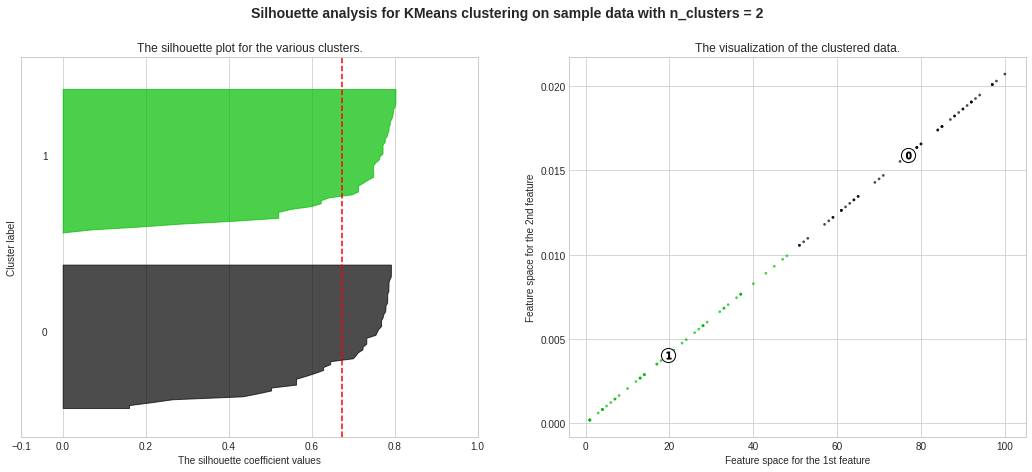

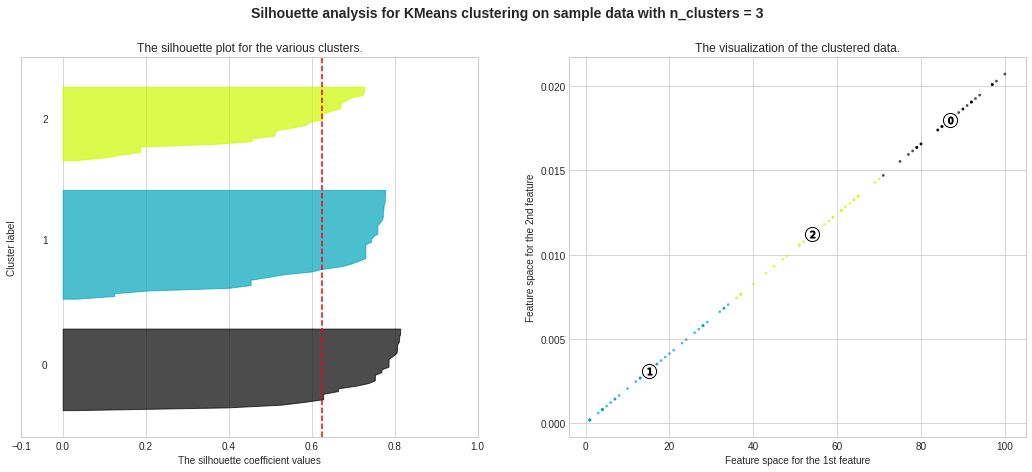

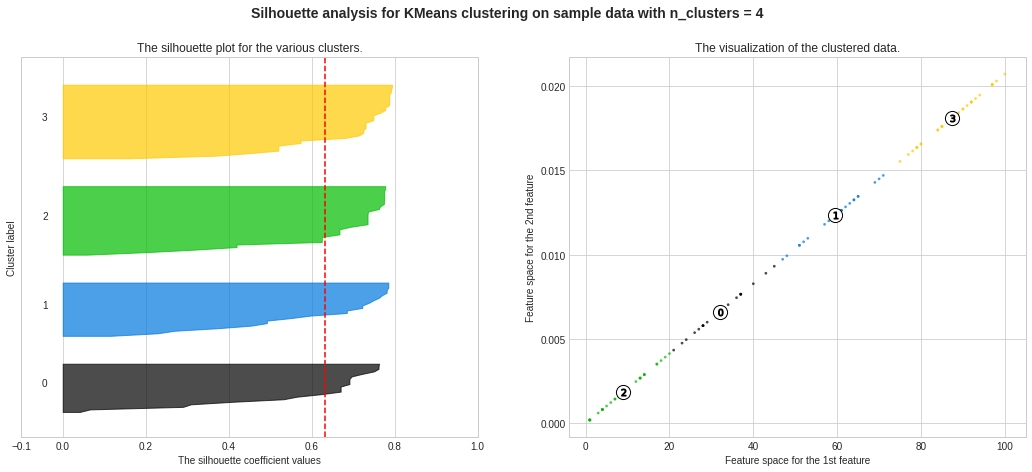

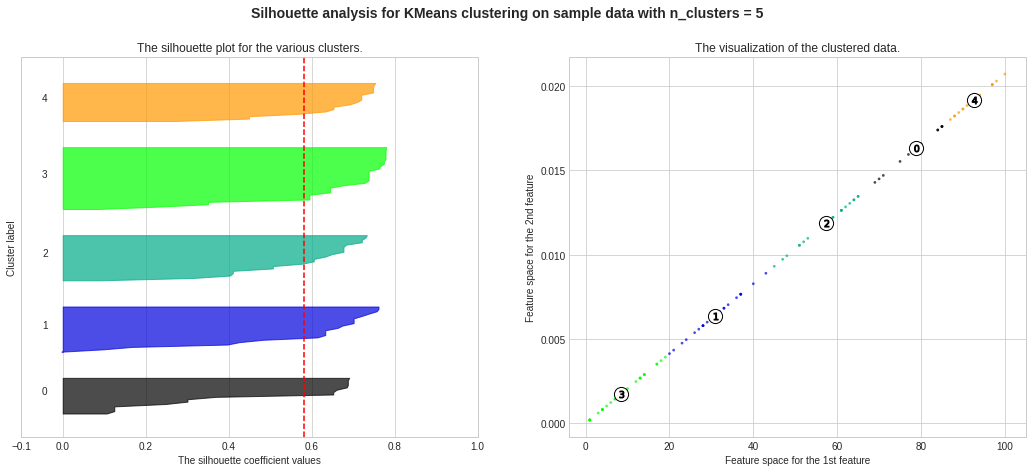

In [9]:
# Without arrival time
data = DataGen(100,False)
#P = DataGen_1(num= 50,mean = 20, std = 83.1789, ok = True)
data = np.transpose(data)
P = data[1,:]
P = np.array(P)
print('Data: ',P)
CTS = TimeSlice_Generator ( P, 20 )
Start_time = [0]*len(P)
Turn_Around_Time,Waiting_Time,NCS  = Round_Robin(P,False,20)
STS = 10
CTS1 = [STS]*len(P)
Turn_Around_Time1,Waiting_Time1,NCS1  = Round_Robin(P,True,20)
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between turn around time:')
print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between waiting time:')
print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
print()
Plot_function(P)

╒════╤════════════════╤════════════════╤════════════════════╕
│    │ Arrival Time   │ Process Time   │ Process priority   │
╞════╪════════════════╪════════════════╪════════════════════╡
│ 0  │ 0              │ 56.661         │ 53                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 1  │ 0              │ 11.2909        │ 23                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 2  │ 0              │ 11.388         │ 65                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 3  │ 0              │ 71.884         │ 63                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 4  │ 0              │ 56.5735        │ 28                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 5  │ 0              │ 17.7907        │ 100                │
├────┼────────────────┼────────────────┼────────────────────┤
│ 6  │ 4              │ 155.374        │ 30                 │
├────┼──

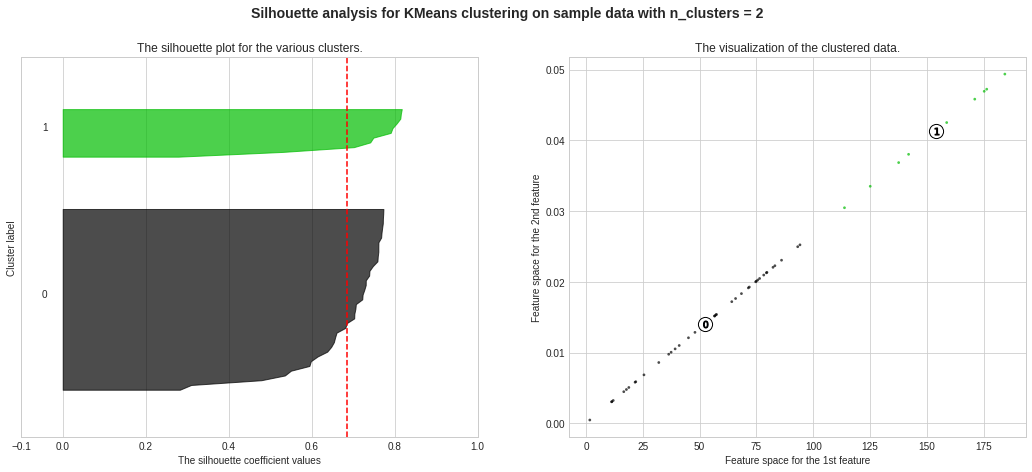

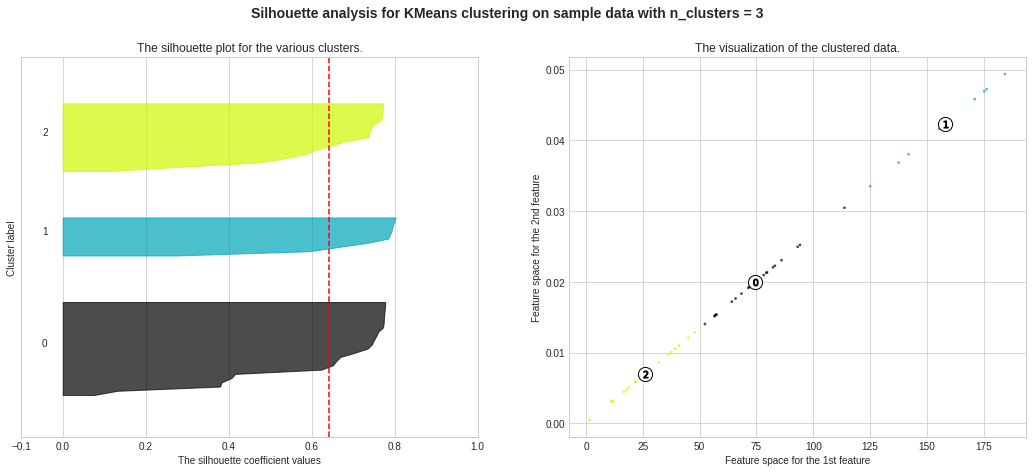

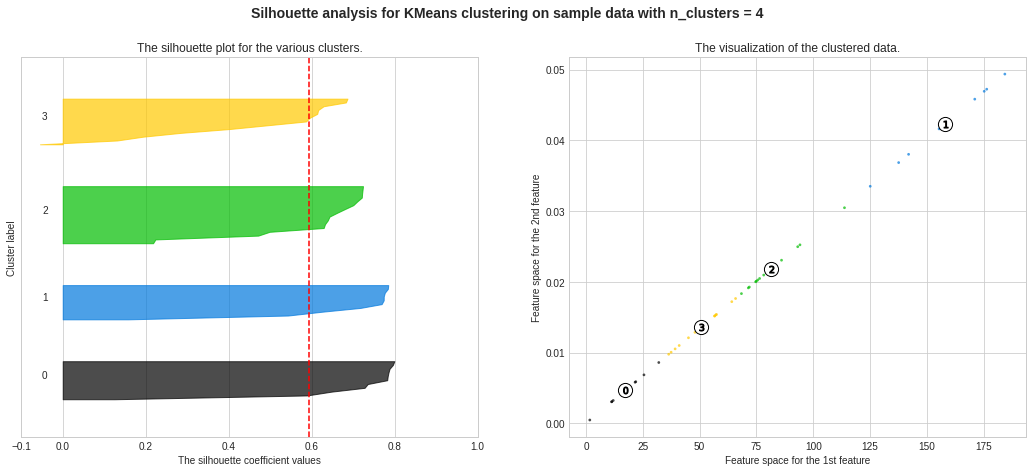

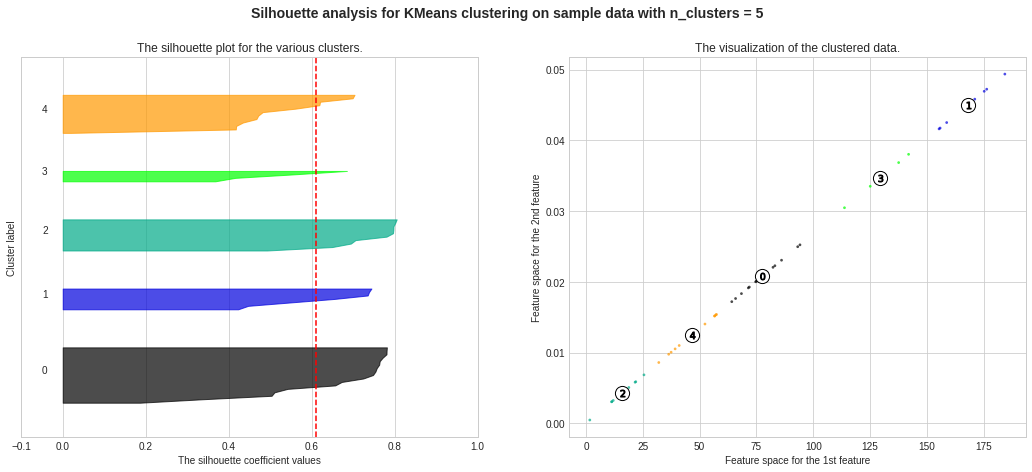

In [10]:
# With arrival time and priority
#Data = DataGen(50)
Data = DataGen_1(num= 50,mean = 20, std = 83.1789)
print(tabulate(Data ,headers=("Arrival Time","Process Time","Process priority"),tablefmt='fancy_grid',showindex=True,numalign="left")) 
Data = np.transpose(Data)
Turn_Around_Time,Waiting_Time,NCS  = Round_Robin_With_AT_and_Priority( Start_time = Data[0,:] ,P =  Data[1,:],Priority = Data[2,:],Simple_RR = False , STS = 20)
Turn_Around_Time1,Waiting_Time1,NCS1  =  Round_Robin_With_AT_and_Priority( Start_time = Data[0,:] ,P =  Data[1,:],Priority = Data[2,:],Simple_RR = True , STS = 20)
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between turn around time:')
print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
print('Comparison between waiting time:')
print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
print('----------------------------------------------------------------------------------------------------------------------------------')
Plot_function(Data[1,:])

In [11]:
STD = [160.2615,83.1789,123.5103,112.4794,103.9525,97.17821,91.67769,87.08775,83.1789]
N = [10,15,20,25,30,35,40,45,50]
Mean = [20,20,20,20,20,20,20,20,20]

In [12]:
# With arrival time
ta, wt,ncs,ta1,wt1,ncs1=[],[],[],[],[],[]
for i in range(len(STD)):
    n  = N[i]
    mean = Mean[i]
    Std = STD[i]
    print("Number of Process: ",n)
    print("Mean of Process: ",mean)
    print("Standard deviation of process: ",Std)
    #Data = DataGen(50)
    Data = DataGen_1(num= n,mean = mean, std = Std)
    print(tabulate(Data ,headers=("Arrival Time","Process Time","Process priority"),tablefmt='fancy_grid',showindex=True,numalign="left")) 
    Data = np.transpose(Data)
    Turn_Around_Time,Waiting_Time,NCS  = Round_Robin_With_AT(Start_time = Data[0,:] ,P =  Data[1,:],Simple_RR = False , STS = 20)
    Turn_Around_Time1,Waiting_Time1,NCS1  =  Round_Robin_With_AT( Start_time = Data[0,:] ,P =  Data[1,:],Simple_RR = True , STS = 20)
    ta.append(Turn_Around_Time.mean())
    ta1.append(Turn_Around_Time1.mean())
    wt.append(Waiting_Time.mean())
    wt1.append(Waiting_Time1.mean())
    ncs.append(NCS)
    ncs1.append(NCS1)
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between turn around time:')
    print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between waiting time:')
    print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    #Plot_function(Data[1,:])
final = np.array([N,Mean,STD,ta,ta1,wt,wt1,ncs,ncs1])
final = np.transpose(final)
print(tabulate(final,headers=("N","Mean","Std","TA","TA1","WT","WT1","NCS","NCS1"),tablefmt='fancy_grid',showindex=True,numalign="left",floatfmt=".3f"))

Number of Process:  10
Mean of Process:  20
Standard deviation of process:  160.2615
╒════╤════════════════╤════════════════╤════════════════════╕
│    │ Arrival Time   │ Process Time   │ Process priority   │
╞════╪════════════════╪════════════════╪════════════════════╡
│ 0  │ 0              │ 214.042        │ 33                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 1  │ 0              │ 106.018        │ 49                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 2  │ 0              │ 172.018        │ 25                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 3  │ 0              │ 87.9038        │ 62                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 4  │ 0              │ 26.8243        │ 54                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 5  │ 0              │ 118.957        │ 3                  │
├────┼────────────────┼────────────────┼───────

In [13]:
# Without arrival time
ta, wt,ncs,ta1,wt1,ncs1=[],[],[],[],[],[]
for i in range(len(STD)):
    n  = N[i]
    mean = Mean[i]
    Std = STD[i]
    print("Number of Process: ",n)
    print("Mean of Process: ",mean)
    print("Standard deviation of process: ",Std)
    data = DataGen_1(num= n,mean = mean, std = Std)
    #P = DataGen_1(num= 50,mean = 20, std = 83.1789, ok = True)
    data = np.transpose(data)
    P = data[1,:]
    P = np.array(P)
    print('Data: ',P)
    CTS = TimeSlice_Generator ( P, 20 )
    Start_time = [0]*len(P)
    Turn_Around_Time,Waiting_Time,NCS = Round_Robin(P,False,20)
    STS = 10
    CTS1 = [STS]*len(P)
    Turn_Around_Time1,Waiting_Time1,NCS1  = Round_Robin(P,True,20)
    ta.append(Turn_Around_Time.mean())
    ta1.append(Turn_Around_Time1.mean())
    wt.append(Waiting_Time.mean())
    wt1.append(Waiting_Time1.mean())
    ncs.append(NCS)
    ncs1.append(NCS1)
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between turn around time:')
    print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between waiting time:')
    print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print()
final1 = np.array([N,Mean,STD,ta,ta1,wt,wt1,ncs,ncs1])
final1 = np.transpose(final1)
print(tabulate(final1,headers=("N","Mean","Std","TA","TA1","WT","WT1","NCS","NCS1"),tablefmt='fancy_grid',showindex=True,numalign="left",floatfmt=".3f"))  


Number of Process:  10
Mean of Process:  20
Standard deviation of process:  160.2615
Data:  [ 77.98100696 224.03233787 130.50926266 181.98217771   1.58120801
 237.46157312  31.27344824 246.2418133  129.74762126 108.73231826]
Number of context in round robin with kmeans:  159
Number of context in normal round robin:  74
----------------------------------------------------------------------------------------------------------------------------------
Comparison between turn around time:
Using K-Means: 845.4001735809331        Using RR: 972.0
----------------------------------------------------------------------------------------------------------------------------------
Comparison between waiting time:
Using K-Means: 708.4458968425658      Using RR: 835.0457232616325
----------------------------------------------------------------------------------------------------------------------------------

Number of Process:  15
Mean of Process:  20
Standard deviation of process:  83.1789
Data:  [ 

In [14]:
# With arrival time and priority
ta, wt,ncs,ta1,wt1,ncs1=[],[],[],[],[],[]
for i in range(len(STD)):
    n  = N[i]
    mean = Mean[i]
    Std = STD[i]
    print("Number of Process: ",n)
    print("Mean of Process: ",mean)
    print("Standard deviation of process: ",Std)
    #Data = DataGen(50)
    Data = DataGen_1(num= n,mean = mean, std = Std)
    print(tabulate(Data ,headers=("Arrival Time","Process Time","Process priority"),tablefmt='fancy_grid',showindex=True,numalign="left")) 
    Data = np.transpose(Data)
    Turn_Around_Time,Waiting_Time,NCS  = Round_Robin_With_AT_and_Priority(Start_time = Data[0,:] ,P =  Data[1,:],Priority = Data[2,:],Simple_RR = False ,STS =10)
    Turn_Around_Time1,Waiting_Time1,NCS1  =  Round_Robin_With_AT_and_Priority( Start_time = Data[0,:] ,P =  Data[1,:],Priority = Data[2,:],Simple_RR = True , STS = 20)
    ta.append(Turn_Around_Time.mean())
    ta1.append(Turn_Around_Time1.mean())
    wt.append(Waiting_Time.mean())
    wt1.append(Waiting_Time1.mean())
    ncs.append(NCS)
    ncs1.append(NCS1)
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between turn around time:')
    print('Using K-Means:', Turn_Around_Time.mean(),'       Using RR:',Turn_Around_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    print('Comparison between waiting time:')
    print('Using K-Means:',Waiting_Time.mean(),'     Using RR:',Waiting_Time1.mean())
    print('----------------------------------------------------------------------------------------------------------------------------------')
    #Plot_function(Data[1,:])
final2 = np.array([N,Mean,STD,ta,ta1,wt,wt1,ncs,ncs1])
final2 = np.transpose(final2)
print(tabulate(final2,headers=("N","Mean","Std","TA","TA1","WT","WT1","NCS","NCS1"),tablefmt='fancy_grid',showindex=True,numalign="left",floatfmt=".3f")) 

Number of Process:  10
Mean of Process:  20
Standard deviation of process:  160.2615
╒════╤════════════════╤════════════════╤════════════════════╕
│    │ Arrival Time   │ Process Time   │ Process priority   │
╞════╪════════════════╪════════════════╪════════════════════╡
│ 0  │ 0              │ 198.138        │ 10                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 1  │ 0              │ 52.9779        │ 24                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 2  │ 0              │ 191.264        │ 29                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 3  │ 0              │ 66.8116        │ 94                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 4  │ 0              │ 86.608         │ 55                 │
├────┼────────────────┼────────────────┼────────────────────┤
│ 5  │ 0              │ 212.79         │ 62                 │
├────┼────────────────┼────────────────┼───────